In [1]:
import os
import sys
import time
from datetime import datetime
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
from model_settings import ms
jupyter_dir = os.path.abspath(str(Path()))
os.chdir(jupyter_dir)
from mlop import mlop
sys.path.append(os.path.join(jupyter_dir,'train_data'))
sys.path.append(os.path.join(
    jupyter_dir,
    'historical_data',
    'historical_generation'))
pd.set_option("display.max_columns",None)
pd.options.display.float_format = '{:.5f}'.format

train_start = time.time()
train_start_datetime = datetime.fromtimestamp(train_start)
train_start_tag = train_start_datetime.strftime('%c')

print("\n"+"#"*18+"\n# training start #\n"+
      "#"*18+"\n"+f"\n{train_start_tag}\n")


pricing settings:
Actual/365 (Fixed) day counter
New York stock exchange calendar
compounding: continuous
frequency: annual


##################
# training start #
##################

Thu Oct 10 11:49:42 2024



# Loading data


importing dataset(s)...



loading: 100%|█████████████████████████████████████████████████████████████████████| 1042/1042 [00:19<00:00, 53.39it/s]



preparing data...


         spot_price  strike_price       barrier  days_to_maturity  \
count 5581703.00000 5581703.00000 5581703.00000     5581703.00000   
mean     1306.92296    1306.06770    1306.86730         329.54428   
min       676.03000     608.42700     338.01500          60.00000   
25%      1253.10000    1219.19102     921.60502          90.00000   
50%      1376.17000    1364.89786    1285.16850         360.00000   
75%      1478.45000    1474.16500    1673.43863         540.00000   
max      1565.18000    1721.69800    2347.77000         720.00000   
std       229.77779     242.13368     470.15872         241.57588   

       barrier_price        rebate  dividend_rate  risk_free_rate  \
count  5581703.00000 5581703.00000  5581703.00000   5581703.00000   
mean        54.60434       0.00000        0.02265         0.04000   
min          0.00000       0.00000        0.01780         0.04000   
25%          3.31101       0.00000        0.01893         0.04000   
50%         

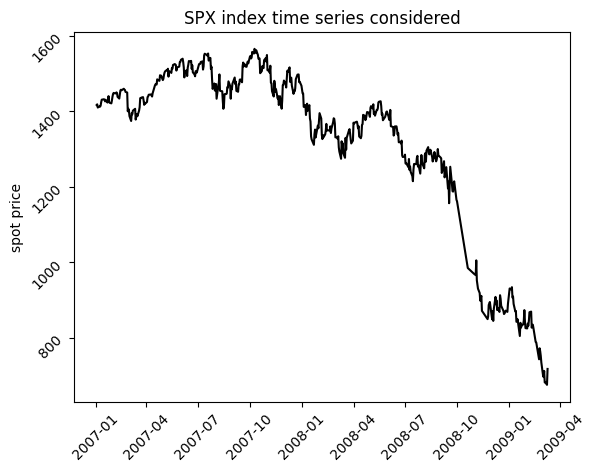

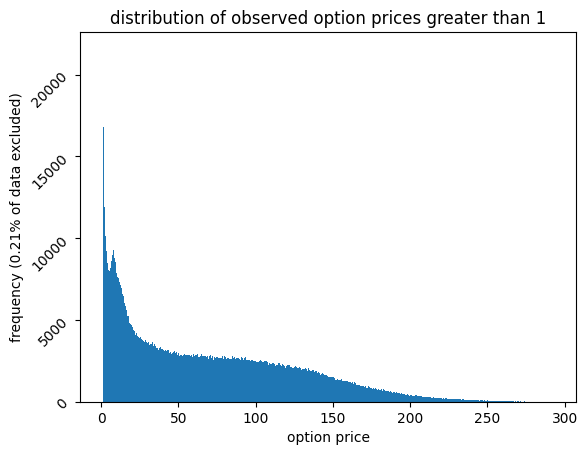

test size: 1.0%
random state: None
maximum iterations: 1000

target: 
observed_price

features: 
['spot_price', 'strike_price', 'days_to_maturity', 'risk_free_rate', 'dividend_rate', 'kappa', 'theta', 'rho', 'eta', 'v0', 'barrier', 'barrier_type_name', 'w']

feature transformer(s):
('StandardScaler', StandardScaler(), ['spot_price', 'strike_price', 'days_to_maturity', 'risk_free_rate', 'dividend_rate', 'kappa', 'theta', 'rho', 'eta', 'v0', 'barrier'])

('OneHotEncoder', OneHotEncoder(sparse_output=False), ['barrier_type_name', 'w'])

target transformer(s):
StandardScaler()



<Figure size 640x480 with 0 Axes>

In [2]:
from HDF_collection import contracts

dataset = contracts.copy()
mlop = mlop(user_dataset = dataset)

# Preprocessing

In [3]:
"""
random train/test split
"""
train_data, train_X, train_y, \
    test_data, test_X, test_y = mlop.split_user_data()

In [4]:
"""
manual train/test split
"""
unique_dates = dataset['calculation_date'].sort_values(
    ascending=True).unique().tolist()
filter_date = unique_dates[int(0.85*len(unique_dates))]

train_data = dataset[
    (
      # (dataset['calculation_date']>=datetime(2007,1,1))
      #  &
        (dataset['calculation_date']<=filter_date)
      )].copy()

test_data = dataset[
    (
      (dataset['calculation_date']>filter_date)
      # &
      # (dataset['calculation_date']<=datetime(2012,12,31))
      )].copy()



In [5]:
"""
preprocessing
"""
train_X, train_y, test_X, test_y = mlop.split_data_manually(
    train_data, test_data)
preprocessor = mlop.preprocess()
train_startdate = train_data.describe()['calculation_date']['min'].strftime('%A, %Y-%m-%d')
train_enddate = train_data.describe()['calculation_date']['max'].strftime('%A, %Y-%m-%d')
print(f"\ntraining from\n{train_startdate}\nto\n{train_enddate}\n")


training from
Wednesday, 2007-01-03
to
Monday, 2008-11-03



In [11]:
print(f"\n{train_data.dtypes}")
test_train_ratio = test_data.describe(
    ).iloc[0,0]/train_data.describe().iloc[0,0]

print(f"\ntrain/test: {int(round((1-test_train_ratio)*100,0))}/"
      +str(int(round(test_train_ratio*100,0))))


spot_price                  float64
strike_price                float64
barrier                     float64
days_to_maturity              int64
barrier_price               float64
updown                       object
outin                        object
w                            object
barrier_type_name            object
rebate                      float64
dividend_rate               float64
risk_free_rate              float64
theta                       float64
kappa                       float64
rho                         float64
eta                         float64
v0                          float64
calculation_date     datetime64[ns]
expiration_date      datetime64[ns]
moneyness                   float64
observed_price              float64
dtype: object

train/test: 80/20


# Training

In [12]:
model_fit, runtime, specs = mlop.run_dnn(preprocessor,train_X,train_y)
train_end = time.time()
train_runtime = train_end-train_start
print(f"\ncpu: {train_runtime}")


training...

Deep Neural Network
hidden layers sizes: (13, 13, 13)
learning rate: constant
activation: relu
solver: sgd
alpha: 0.0001

cpu: 879.7736015319824


# Testing

In [13]:
test_data.describe()

,spot_price,strike_price,barrier,days_to_maturity,barrier_price,rebate,dividend_rate,risk_free_rate,theta,kappa,rho,eta,v0,calculation_date,expiration_date,moneyness,observed_price
count,914130.00000,914130.00000,914130.00000,914130.00000,914130.00000,914130.00000,914130.00000,914130.00000,914130.00000,914130.00000,914130.00000,914130.00000,914130.00000,914130,914130,914130.00000,914130.00000
mean,845.42078,845.39106,845.57056,325.09852,58.39169,0.00000,0.03291,0.04000,0.14192,4.31259,-0.99992,0.25323,0.20406,2009-01-10 14:21:50.418430976,2009-12-01 16:43:42.538151680,1.95812,58.39564
min,676.03000,608.42700,338.01500,60.00000,0.00000,0.00000,0.02827,0.04000,0.11522,0.91936,-1.00000,0.19276,0.09981,2008-11-04 00:00:00,2009-01-03 00:00:00,-0.94575,0.00000
25%,826.55000,792.64196,625.87395,90.00000,7.00700,0.00000,0.03203,0.04000,0.13053,2.80113,-1.00000,0.21908,0.15215,2008-12-12 00:00:00,2009-04-27 00:00:00,-0.70721,7.00426
50%,857.33000,849.32737,848.75670,360.00000,43.28167,0.00000,0.03292,0.04000,0.13674,3.69742,-0.99999,0.25015,0.17695,2009-01-12 00:00:00,2009-10-30 00:00:00,-0.00286,43.27579
75%,888.94000,905.60204,1058.26463,540.00000,98.18251,0.00000,0.03406,0.04000,0.15301,5.58025,-0.99989,0.28262,0.26178,2009-02-10 00:00:00,2010-07-07 00:00:00,1.92393,98.18871
max,1005.42000,1105.96200,1508.13000,720.00000,253.83195,0.00000,0.03560,0.04000,0.19559,12.31060,-0.99922,0.43651,0.38708,2009-03-10 00:00:00,2011-02-28 00:00:00,17.43270,253.69872
std,67.14607,83.64351,272.84312,241.49723,56.32248,0.00000,0.00135,0.00000,0.01682,2.46292,0.00014,0.04331,0.07286,NaN,NaN,4.24193,56.31862


In [14]:
insample, outsample, errors = mlop.test_prediction_accuracy(
        model_fit,
        test_data,
        train_data
        )


in sample:
     RSME: 5.356772572248143
     MAE: 3.6196318442745268

out of sample:
     RSME: 17.384060532676404
     MAE: 12.58775891004171


# Saving

In [15]:
train_end_tag = str(datetime.fromtimestamp(
    train_end).strftime("%Y_%m_%d %H-%M-%S"))
file_tag = str(train_end_tag + " " + specs[0] )
os.chdir(os.path.join(jupyter_dir,'trained_models'))
files_dir = os.path.join(
    jupyter_dir,'trained_models','trained_models',
    file_tag)

if Path(files_dir).exists():
    pass
else:
    os.mkdir(files_dir)

file_dir = os.path.join(files_dir,file_tag)

S = np.sort(train_data['spot_price'].unique())
K = np.sort(train_data['strike_price'].unique())
T = np.sort(train_data['days_to_maturity'].unique())
W = np.sort(train_data['w'].unique())
n_calls = train_data[train_data['w']=='call'].shape[0]
n_puts = train_data[train_data['w']=='put'].shape[0]
insample.to_csv(f"{file_dir} insample.csv")
outsample.to_csv(f"{file_dir} outsample.csv")
joblib.dump(model_fit,str(f"{file_dir}.pkl"))
pd.set_option("display.max_columns",None)
with open(f'{file_dir}.txt', 'w') as file:
    file.write(train_start_tag)
    file.write(f"\nspot(s):\n{S}")
    file.write(f"\n\nstrikes:\n{K}\n")
    file.write(f"\nmaturities:\n{T}\n")
    file.write(f"\ntypes:\n{W}\n")
    try:
        file.write(f"\n{train_data['barrier_type_name'].unique()}")
    except Exception:
        pass
    file.write("")
    file.write(f"\nnumber of calls, puts:\n{n_calls},{n_puts}\n")
    file.write(f"\ntotal prices:\n{train_data.shape[0]}\n")
    for spec in specs:
        file.write(f"{spec}\n")
    file.write("#"*17+"\n# training data #\n"+"#"*17+
          f"\n{train_data.describe()}\n")
    file.write("#"*13+"\n# test data #\n"+"#"*13+
          f"\n{test_data.describe()}\n")
    file.write(f"\n{dataset.dtypes}")
    file.write(
        f"\nin sample results:"
        f"\n     RMSE: {errors['insample_RMSE']}"
        f"\n     MAE: {errors['insample_MAE']}\n"
        f"\nout of sample results:"
        f"\n     RMSE: {errors['outofsample_RMSE']}"
        f"\n     MAE: {errors['outofsample_MAE']}\n"
        )
    file.write("\nfeatures:\n")
    for feature in mlop.feature_set:
        file.write(f"     {feature}\n")
    file.write(f"\ntarget: {mlop.target_name}\n")
    file.write(f"\ncpu: {train_runtime}\n")
    file.write(datetime.fromtimestamp(train_end).strftime('%c'))